# Comparing the selected models and parameters

In [2]:
# imports

import os
import h5py
import time
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from pandas import DataFrame
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GridSearchCV
%matplotlib inline

Setup common evaluation, plotting, folder loc etc. based on previous experiments (notebooks 1-3)

In [39]:
# Read the file from DS02
filename = '../data/N-CMAPSS_DS02.h5'

# Setup save loc for graphs
graph_folder = '../graphs/'

# evaluation function
def evaluate(actual, pred, label=None):
    mse = mean_squared_error(actual, pred)
    rmse = np.sqrt(mse)
    variance = r2_score(actual, pred)
    print(f'{label} RMSE: {rmse:.2f} Variance: {variance:.2f}')

# setup pred vs actual plotting function
def plot_pred_vs_actual(pred, actual, label='Prediction', save=False):
    plt.plot(pred, color="green", label="Predicted")
    plt.plot(actual, color="orange", label="Actual")
    plt.title(label)
    plt.ylabel('value')
    plt.xlabel('row')
    plt.legend(loc='upper right')
    if save:
        plt.savefig(graph_folder + f'evaluation_{label}.jpeg')
    plt.show()

Read data, pre-process based on findings from eda etc. (previous notebooks)

In [4]:
# Load data
with h5py.File(filename, 'r') as hdf:
        # Development set
        W_dev = np.array(hdf.get('W_dev'))             # W
        X_s_dev = np.array(hdf.get('X_s_dev'))         # X_s
        X_v_dev = np.array(hdf.get('X_v_dev'))         # X_v
        T_dev = np.array(hdf.get('T_dev'))             # T
        Y_dev = np.array(hdf.get('Y_dev'))             # RUL  
        A_dev = np.array(hdf.get('A_dev'))             # Auxiliary

        # Test set
        W_test = np.array(hdf.get('W_test'))           # W
        X_s_test = np.array(hdf.get('X_s_test'))       # X_s
        X_v_test = np.array(hdf.get('X_v_test'))       # X_v
        T_test = np.array(hdf.get('T_test'))           # T
        Y_test = np.array(hdf.get('Y_test'))           # RUL  
        A_test = np.array(hdf.get('A_test'))           # Auxiliary
        
        # Varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))
        
        # from np.array to list dtype U4/U5
        W_var = list(np.array(W_var, dtype='U20'))
        X_s_var = list(np.array(X_s_var, dtype='U20'))  
        X_v_var = list(np.array(X_v_var, dtype='U20')) 
        T_var = list(np.array(T_var, dtype='U20'))
        A_var = list(np.array(A_var, dtype='U20'))
                          
W = np.concatenate((W_dev, W_test), axis=0)  
X_s = np.concatenate((X_s_dev, X_s_test), axis=0)
X_v = np.concatenate((X_v_dev, X_v_test), axis=0)
T = np.concatenate((T_dev, T_test), axis=0)
Y = np.concatenate((Y_dev, Y_test), axis=0) 
A = np.concatenate((A_dev, A_test), axis=0) 

In [5]:
# define meaningful names for the variables
# Auxiliary data
auxiliary_cols = ['unit','cycle','flight_class','health_state']
df_A_train = DataFrame(data=A_dev, columns=auxiliary_cols)
df_A_test = DataFrame(data=A_test, columns=auxiliary_cols)

# Scenario descriptors
scenario_cols = ['altitude','mach_number','throttle_resolver_angle','fan_inlet_temp']
df_W_train = DataFrame(data=W_dev, columns=scenario_cols)
df_W_test = DataFrame(data=W_test, columns=scenario_cols)

# Measurements
physical_sensor_cols = [
    'fuel_flow','physical_fan_speed','physical_core_speed','lpc_temp','hpc_temp','hpt_temp','lpt_temp',
    'bypass_duct_temp','fan_in_pressure','fan_out_pressure','lpc_pressure','hpc_static_pressure','burner_out_pressure','lpt_pressure'
    ]
df_X_s_train = DataFrame(data=X_s_dev, columns=physical_sensor_cols)
df_X_s_test = DataFrame(data=X_s_test, columns=physical_sensor_cols)


# Virtual sensors
virtual_sensor_cols = [
    'total_temp_burner_outlet','total_pressure_hpc_outlet','total_pressure_hpt_outlet','fan_flow','lpc_outflow',
    'hpc_inflow','hpt_coolant_bleed','lpt_coolant_bleed','hpt_outflow','lpt_outflow','fan_stall_margin',
    'lpc_stall_margin','hpc_stall_margin','ratio_fuel_flow_to_static_hpc_pressure'
]
df_X_v_train = DataFrame(data=X_v_dev, columns=virtual_sensor_cols)
df_X_v_test = DataFrame(data=X_v_test, columns=virtual_sensor_cols)

# Health parameters
health_param_cols = [
    'fan_efficiency_mod','fan_flow_mod','lpc_efficiency_mod','lpc_flow_mod','hpc_efficiency_mod','hpc_flow_mod',
    'hpt_efficiency_mod','hpt_flow_mod','lpt_efficiency_mod','lpt_flow_mod'
]
df_T_dev = DataFrame(data=T_dev, columns=health_param_cols)
df_T_test = DataFrame(data=T_test, columns=health_param_cols)


# RUL
df_Y_train = DataFrame(data=Y_dev, columns=['RUL'])
df_Y_test = DataFrame(data=Y_test, columns=['RUL'])


# exclude df_T health parameters, health state, flight class
df_train = pd.concat([df_A_train, df_W_train, df_X_s_train, df_X_v_train, df_Y_train], axis=1).drop(['health_state', 'flight_class'], axis=1)
df_test = pd.concat([df_A_test, df_W_test, df_X_s_test, df_X_v_test, df_Y_test], axis=1).drop(['health_state', 'flight_class'], axis=1)

In [6]:
# Make the units into categorical variables
df_train.unit = df_train.unit.astype('int')
df_test.unit = df_test.unit.astype('int')

Divide the data into testing and training sets based on the original h5 file.
Enigines 2,5,10,16,18,20 will be in the training data, and 11,14,15 will be in the test dataset.

In [7]:
x_train = df_train.drop(['RUL','unit', 'cycle','altitude','mach_number','throttle_resolver_angle','fan_inlet_temp'], axis=1)
y_train = df_train['RUL']

x_test = df_test.drop(['RUL','unit', 'cycle','altitude','mach_number','throttle_resolver_angle','fan_inlet_temp'], axis=1)
y_test = df_test['RUL']

Get the engine units seperately for LeaveOneGroupOut cross validation, and split for the cv function to be passed to grid search.

In [8]:
train_engines = df_train['unit']
logo = LeaveOneGroupOut().split(x_train, y_train, train_engines)

Define the params for grid search - limited based on memory/resource constraints as identified in previous experiments.

In [32]:
ridge_params = {'alpha': [0.1, 1.0, 10.0]}
xgboost_params = {'max_depth': [2, 6, 10], 'subsample': [0.5, 0.7, 0.9], 'colsample_by_tree': [0.5, 0.7, 0.9]}
rf_params = {'n_estimators': [10, 20, 50], 'min_samples_leaf': [2, 1000, 40000], 'min_samples_split': [2, 1000, 40000], 'max_features': [0.1, 0.5, 1.0], 'max_depth': [2, 6, 10]}

Find params for ridge regression

In [29]:
ridge_grid = GridSearchCV(Ridge(), ridge_params, cv=logo, scoring=['neg_mean_squared_error', 'r2'], refit='r2')
ridge_grid.fit(x_train, y_train)

GridSearchCV(cv=<generator object BaseCrossValidator.split at 0x7fa08b844120>,
             estimator=Ridge(), param_grid={'alpha': [0.1, 1.0, 10.0]},
             refit='r2', scoring=['neg_mean_squared_error', 'r2'])

In [30]:
print(f'Train score: {ridge_grid.best_estimator_.score(x_train, y_train)}')
print(f'Test score: {ridge_grid.best_estimator_.score(x_test, y_test)}')
print(f'Best params: {ridge_grid.best_params_}')

Train score: 0.7341677442269746
Test score: 0.6426887869205007
Best params: {'alpha': 10.0}


Find params for xgboost

In [34]:
cv = LeaveOneGroupOut().split(x_train, y_train, train_engines)
xg_grid = GridSearchCV(XGBRegressor(), xgboost_params, cv=cv, scoring=['neg_mean_squared_error', 'r2'], refit='r2')
xg_grid.fit(x_train, y_train)

[14:03:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "colsample_by_tree" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:03:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "colsample_by_tree" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:04:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/bu

GridSearchCV(cv=<generator object BaseCrossValidator.split at 0x7fa0591cd580>,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                

In [36]:
print(f'Train score: {xg_grid.best_estimator_.score(x_train, y_train)}')
print(f'Test score: {xg_grid.best_estimator_.score(x_test, y_test)}')
print(f'Best params: {xg_grid.best_params_}')

Train score: 0.9351430088873514
Test score: 0.8114955444880284
Best params: {'colsample_by_tree': 0.5, 'max_depth': 10, 'subsample': 0.9}


Find params for rf regression

In [37]:
cv = LeaveOneGroupOut().split(x_train, y_train, train_engines)
rf_grid = GridSearchCV(RandomForestRegressor(), rf_params, cv=cv, scoring=['neg_mean_squared_error', 'r2'], refit='r2')
rf_grid.fit(x_train, y_train)

In [ ]:
print(f'Train score: {rf_grid.best_estimator_.score(x_train, y_train)}')
print(f'Test score: {rf_grid.best_estimator_.score(x_test, y_test)}')
print(f'Best params: {rf_grid.best_params_}')

Rebuilding RF regression model with new params after accidentally rerunning and cancelling the previous two cells - takes ~24 hours to complete full training!

In [11]:
rf = RandomForestRegressor(n_estimators=20, min_samples_leaf = 40000, min_samples_split = 2, max_features = 1.0, max_depth = 6, verbose=4)
rf.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 20


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   58.6s remaining:    0.0s


building tree 2 of 20


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.9min remaining:    0.0s


building tree 3 of 20


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.9min remaining:    0.0s


building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 19.4min finished


RandomForestRegressor(max_depth=6, max_features=1.0, min_samples_leaf=40000,
                      n_estimators=20, verbose=4)

In [12]:
rf.score(x_train, y_train)
rf.score(x_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.3s finished


0.42922105760689677

In [13]:
y_pred_train = rf.predict(x_train)
y_pred_test = rf.predict(x_test)

evaluate(y_train, y_pred_train, label='rf_train')
evaluate(y_test, y_pred_test, label='rf_test')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s


rf_train RMSE: 16.55 Variance: 0.45
rf_test RMSE: 14.33 Variance: 0.43


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.3s finished


### Define the 3 'best' parametric models for comparison

* Ridge - alpha = 10.0
* XGBoost - max_depth = 10, subsample = 0.9, colsample_by_tree = 0.5
* Random Forest - n_estimators = 20, min_samples_leaf - 40000, min_samples_split = 2, max_features = 1.0, max_depth = 6

In [22]:
models = {
    'ridge': Ridge(alpha=0.1),
    'xgboost': XGBRegressor(max_depth=10, subsample=0.9),
    'random_forest': RandomForestRegressor(n_estimators=20, min_samples_leaf = 40000, min_samples_split = 2, max_features = 1.0, max_depth = 6, verbose=4)
}

In [17]:
import sklearn 
print(sorted(sklearn.metrics.SCORERS.keys()))

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'rand_score', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weighted', 'roc_auc_ovr', 'roc_auc_ovr_weighted', 'top_k_accuracy', 'v_measure_score']


In [23]:
from sklearn.model_selection import cross_val_score

results = []
for name, model in models.items():
    logo = LeaveOneGroupOut().split(x_train, y_train, train_engines)
    scores = cross_val_score(model, x_train, y_train, cv=logo, scoring='neg_root_mean_squared_error', verbose=2)
    results.append([name, scores.mean(), scores.std(), scores.min(), scores.max()])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   3.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s


[CV] END .................................................... total time=   2.5s
[CV] END .................................................... total time=   2.6s
[CV] END .................................................... total time=   3.1s
[CV] END .................................................... total time=   2.4s
[CV] END .................................................... total time=   2.6s


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   16.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=  37.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   37.7s remaining:    0.0s


[CV] END .................................................... total time=  34.8s
[CV] END .................................................... total time=  35.7s
[CV] END .................................................... total time=  37.1s
[CV] END .................................................... total time=  37.9s
[CV] END .................................................... total time=  36.9s


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  3.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 20


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   47.9s remaining:    0.0s


building tree 2 of 20


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s


building tree 3 of 20


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.4min remaining:    0.0s


building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 15.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 15.9min remaining:    0.0s


[CV] END .................................................... total time=15.9min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 20


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   45.4s remaining:    0.0s


building tree 2 of 20


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.5min remaining:    0.0s


building tree 3 of 20


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.3min remaining:    0.0s


building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 15.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.2s finished


[CV] END .................................................... total time=15.0min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 20


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   46.2s remaining:    0.0s


building tree 2 of 20


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.5min remaining:    0.0s


building tree 3 of 20


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.3min remaining:    0.0s


building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 31.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.2s finished


[CV] END .................................................... total time=31.0min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 20


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   48.7s remaining:    0.0s


building tree 2 of 20


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s


building tree 3 of 20


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.4min remaining:    0.0s


building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 16.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.2s finished


[CV] END .................................................... total time=16.2min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 20


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   46.3s remaining:    0.0s


building tree 2 of 20


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.5min remaining:    0.0s


building tree 3 of 20


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.3min remaining:    0.0s


building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 15.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.2s finished


[CV] END .................................................... total time=15.6min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 20


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   48.8s remaining:    0.0s


building tree 2 of 20


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s


building tree 3 of 20


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.4min remaining:    0.0s


building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 16.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s


[CV] END .................................................... total time=16.2min


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 110.1min finished


In [24]:
results_df = pd.DataFrame(results, columns=['model', 'mean', 'std', 'min', 'max'])
print(results_df)

           model       mean       std        min        max
0          ridge -12.627467  2.364688 -16.022771  -9.547721
1        xgboost  -9.806534  1.900243 -12.759900  -7.879215
2  random_forest -17.472783  2.490112 -20.964297 -13.844442


In [25]:
ridge_model = models['ridge']
xgboost_model = models['xgboost']
rf_model = models['random_forest']

Ridge regression model individual scores and plot

In [26]:
ridge_model.fit(x_train, y_train)
ridge_pred_train = ridge_model.predict(x_train)
ridge_pred_test = ridge_model.predict(x_test)
evaluate(y_train, ridge_pred_train, label='ridge_train')
evaluate(y_test, ridge_pred_test, label='ridge_test')

ridge_train RMSE: 11.49 Variance: 0.74
ridge_test RMSE: 11.39 Variance: 0.64


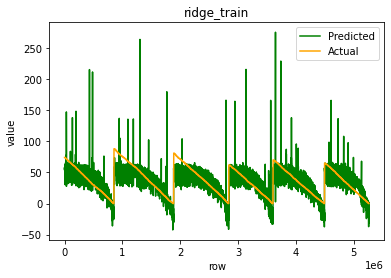

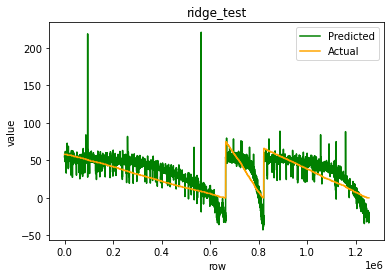

In [41]:
plot_pred_vs_actual(ridge_pred_train, y_train, label='ridge_train', save=True)
plot_pred_vs_actual(ridge_pred_test, y_test, label='ridge_test', save=True)

XGBoost model individual scores and plots

In [28]:
xgboost_model.fit(x_train, y_train)
xgboost_pred_train = xgboost_model.predict(x_train)
xgboost_pred_test = xgboost_model.predict(x_test)
evaluate(y_train, xgboost_pred_train, label='xgboost_train')
evaluate(y_test, xgboost_pred_test, label='xgboost_test')

xgboost_train RMSE: 5.70 Variance: 0.94
xgboost_test RMSE: 8.23 Variance: 0.81


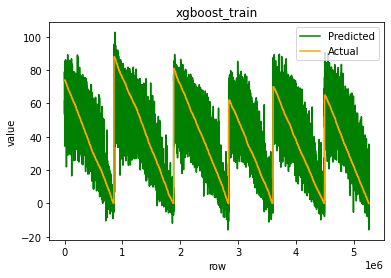

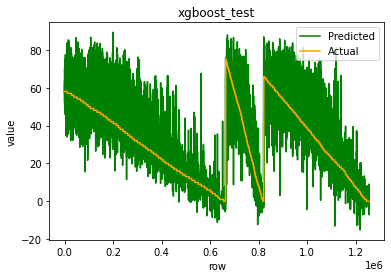

In [40]:
plot_pred_vs_actual(xgboost_pred_train, y_train, label='xgboost_train', save=True)
plot_pred_vs_actual(xgboost_pred_test, y_test, label='xgboost_test', save=True)

Random forest regression individual scores and plots

In [30]:
rf_model.fit(x_train, y_train)
rf_pred_train = rf_model.predict(x_train)
rf_pred_test = rf_model.predict(x_test)
evaluate(y_train, rf_pred_train, label='rf_train')
evaluate(y_test, rf_pred_test, label='rf_test')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 20


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min remaining:    0.0s


building tree 2 of 20


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.0min remaining:    0.0s


building tree 3 of 20


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.0min remaining:    0.0s


building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 19.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s


rf_train RMSE: 16.52 Variance: 0.45
rf_test RMSE: 14.23 Variance: 0.44


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.3s finished


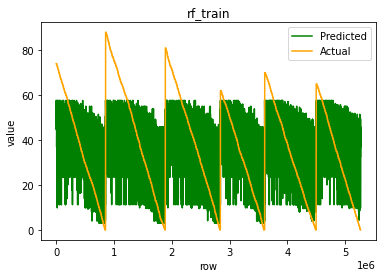

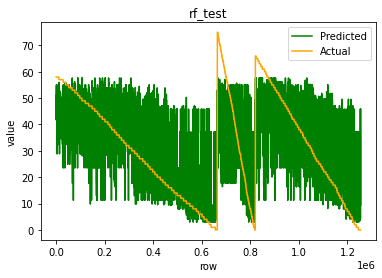

In [42]:
plot_pred_vs_actual(rf_pred_train, y_train, label='rf_train', save=True)
plot_pred_vs_actual(rf_pred_test, y_test, label='rf_test', save=True)